In [77]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

In [2]:
dataset_dir="../input/ranzcr-clip-catheter-line-classification/"

train=pd.read_csv(dataset_dir+"train.csv")
display(train["PatientID"].value_counts())

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
b1073638c      1
a646e1291      1
fa3b705b2      1
7173e4b8f      1
eab60ea65      1
Name: PatientID, Length: 3255, dtype: int64

In [72]:
target_cols=list(train.iloc[:,1:-1].columns)
n_folds=4

In [73]:
group_kfold=GroupKFold(n_splits=n_folds)
groups=train["PatientID"].unique()

folds=train.copy()

for n,(train_index,test_index) in enumerate(group_kfold.split(train,groups=train["PatientID"])):
    folds.loc[test_index,"fold"]=n

folds["fold"]=folds["fold"].astype(int)
display(folds)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,fold
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1,2
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c,2
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5,0
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814,0
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30078,1.2.826.0.1.3680043.8.498.74257566841157531124...,0,0,1,0,0,0,0,0,1,1,0,5b5b9ac30,2
30079,1.2.826.0.1.3680043.8.498.46510939987173529969...,0,0,0,0,0,0,0,0,0,1,0,7192404d8,2
30080,1.2.826.0.1.3680043.8.498.43173270582850645437...,0,0,1,0,0,1,0,1,0,1,0,d4d1b066d,3
30081,1.2.826.0.1.3680043.8.498.95092491950130838685...,0,0,0,0,0,0,0,0,1,0,0,01a6602b8,1


In [42]:
annot_df=pd.read_csv(f"{dataset_dir}train_annotations.csv")
annot_df.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


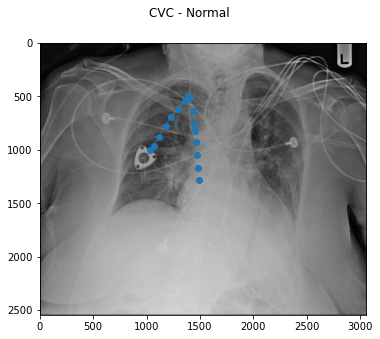

In [56]:
index=0
annot_data=pd.DataFrame(np.array(eval(annot_df.loc[index,"data"])))
uid=annot_df.loc[index,'StudyInstanceUID']
img=cv2.imread(f"{dataset_dir}train/{uid}.jpg")
img_r=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
label=annot_df.loc[index,"label"]

fig,axes=plt.subplots(1,1,figsize=(15,5))
fig.suptitle(label)
axes.imshow(img_r)
axes.scatter(annot_data.loc[:,0],annot_data.loc[:,1])

In [79]:
def visualize_annotations(file_id):
    plt.figure(figsize=(15, 8))
    
    image = cv2.imread(f"{dataset_dir}train/{file_id}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
    df_patient = annot_df.loc[annot_df["StudyInstanceUID"] == file_id]
    
    if df_patient.shape[0]:        
        labels = df_patient["label"].values.tolist()
        lines = df_patient["data"].apply(eval).values.tolist()

        for line, label in zip(lines, labels):         
            line = np.asarray(line)
            plt.scatter(line[:, 0], line[:, 1], s=40, label=label)
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, prop={'size': 20})
        
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    
    plt.savefig(f"../input/annotated/{file_id}.png")

for uid in tqdm(annot_df["StudyInstanceUID"].unique()):
    visualize_annotations(uid)

 12%|█▏        | 1078/9095 [16:44<2:04:28,  1.07it/s]


MemoryError: Unable to allocate 29.7 MiB for an array with shape (2544, 3056, 4) and data type uint8